In [66]:
import gdal, osr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def raster2array(rasterfn):
    print('converting raster to array...')
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array

In [5]:
ecoCost = raster2array(os.path.abspath('01_Data500/fac_eco.tif'))
envCost = raster2array(os.path.abspath('01_Data500/fac_env.tif'))
infCost = raster2array(os.path.abspath('01_Data500/fac_inf.tif'))
pubCost = raster2array(os.path.abspath('01_Data500/fac_pub.tif'))
allCost = (ecoCost+envCost+infCost+pubCost)/4

converting raster to array...
converting raster to array...
converting raster to array...
converting raster to array...


## Select DC and path_based_on

In [10]:
dc ='dc5'
path_based_on = 'all'
pathFile = os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'

In [62]:
factors = ['eco','env','inf','pub', 'all']

In [21]:
def line_path(path_based_on, dc):
    pathFl =  os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'
    return raster2array(pathFl)

In [14]:
linePath = linePath(path_based_on='all', dc = 'dc5')

converting raster to array...


In [22]:
def getCosts(path_based_on, dc):
    linePath = line_path(path_based_on=path_based_on, dc = dc)
    ecoCostLine = np.multiply(ecoCost, linePath).sum()
    envCostLine = np.multiply(envCost, linePath).sum()
    infCostLine = np.multiply(infCost, linePath).sum()
    pubCostLine = np.multiply(pubCost, linePath).sum()
    allCostLine = np.multiply(allCost, linePath).sum()
    return [ecoCostLine, envCostLine, infCostLine, pubCostLine, allCostLine]

In [120]:
def allCosts(line):
    cost = []
    for factor in factors:
        print(factor)
        facCost = getCosts(path_based_on=factor, dc=line)
        cost.append(facCost)
    allCost = pd.DataFrame(cost)
    allCost.columns=['eco','env','inf','pub','all']
    allCost['path_on'] = ['p_eco','p_env','p_inf','p_pub','p_all']
    return allCost.set_index('path_on')


In [121]:
dc5 = allCosts('dc5')

eco
converting raster to array...
env
converting raster to array...
inf
converting raster to array...
pub
converting raster to array...
all
converting raster to array...


In [125]:
dc3 = allCosts('dc3')

eco
converting raster to array...
env
converting raster to array...
inf
converting raster to array...
pub
converting raster to array...
all
converting raster to array...


In [127]:
dc4 = allCosts('dc4')

eco
converting raster to array...
env
converting raster to array...
inf
converting raster to array...
pub
converting raster to array...
all
converting raster to array...


In [157]:
colors = ['blue','green','firebrick', 'm','gray']

In [133]:
from matplotlib.colors import ListedColormap

In [166]:
def bar_diff(data):
    cmap = ListedColormap(colors)
    data.plot(kind='bar',cmap=cmap)
    plt.show()
    data.sub(data.xs('p_all'),axis=1).plot(kind='bar',cmap=cmap)
    plt.show()
    data.sub(data.xs('p_all'), axis=1).div(data.xs('p_all'),axis=1).plot(kind='bar', cmap=cmap)
    plt.show()

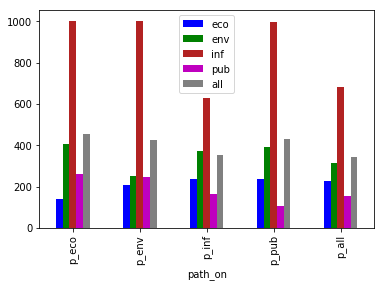

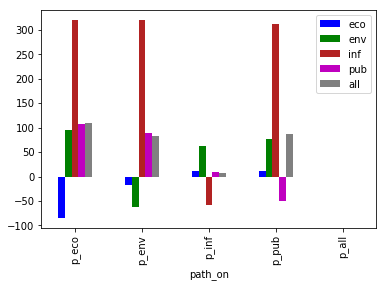

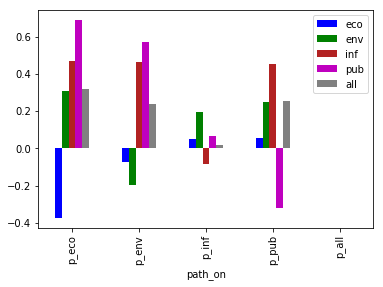

In [167]:
bar_diff(dc3)

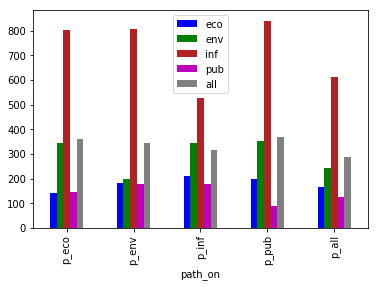

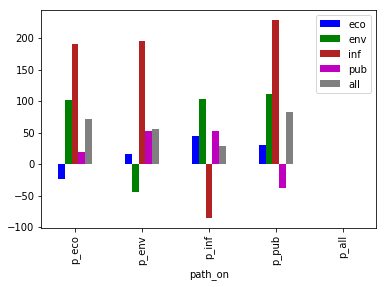

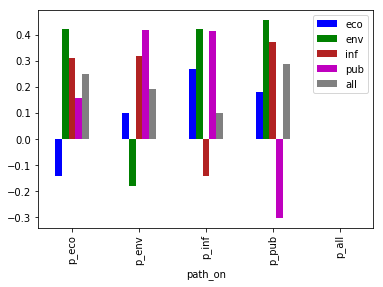

In [168]:
bar_diff(dc4)

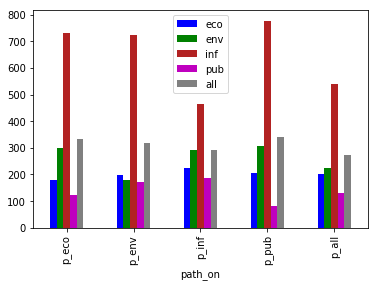

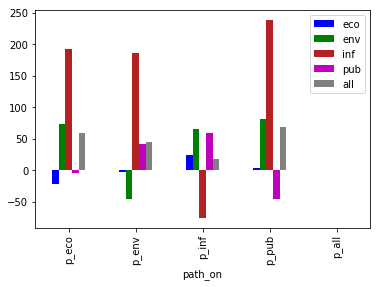

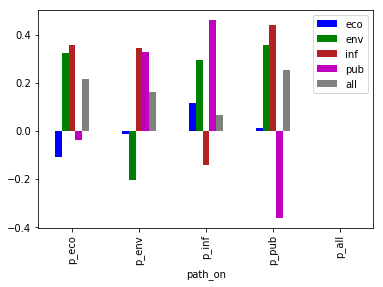

In [169]:
bar_diff(dc5)

In [171]:
infCost = raster2array(os.path.abspath('01_Data500/fac_inf.tif'))

converting raster to array...


In [174]:
infCost.max()

0.99

In [177]:
pd.DataFrame(infCost).describe()

,0,1,2,3,4,5,6,7,8,9,...,8827,8828,8829,8830,8831,8832,8833,8834,8835,8836
count,8685.00,8685.00,8685.00,8685.00,8685.00,8685.00,8685.00,8685.00,8685.00,8685.00,...,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.986618,0.987340,0.986998,0.986466,0.985744,0.986428,0.987112,0.986808,0.986884,0.987188
std,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.033236,0.029508,0.031332,0.033967,0.037234,0.034147,0.030736,0.032299,0.031915,0.030333
min,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.660000,0.660000,0.660000,0.660000,0.660000,0.660000,0.660000,0.660000,0.660000,0.660000
25%,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000
50%,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000
75%,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000
max,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000,0.990000


In [176]:
np.unique(infCost)

array([0.  , 0.33, 0.66, 0.99], dtype=float32)

In [175]:
infCost.min()

0.0

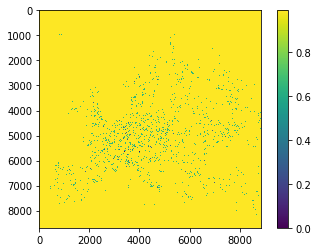

In [173]:
plt.imshow(infCost)
plt.colorbar()
plt.show()